In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_excel("Fire_Weather_Data.xlsx")

# splitting the remaining data in training data and validation data. 
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, shuffle = False)
df_train.index = range(df_train.shape[0])
df_test.index = range(df_test.shape[0])

# Scaling the data using MinMax Scaler.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_train.drop(["FWI"],axis=1).values)
Y_train = scaler.fit_transform(df_train["FWI"].values.reshape(-1,1))
X_test = scaler.fit_transform(df_test.drop(["FWI"],axis=1).values)
Y_test = scaler.fit_transform(df_test["FWI"].values.reshape(-1,1))

# function to denormalise the predicted values.
def denormalize(df,norm_data):
    df = df["FWI"].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    
    return new

# defining weights and biases for the nn layers.
input_features = 10

W_1 = tf.Variable(tf.random_uniform([input_features,15])) # weights corresponding to first hidden/input layer.
b_1 = tf.Variable(tf.zeros([15]))

W_2 = tf.Variable(tf.random_uniform([15,15])) # weights corresponding to second hidden layer.
b_2 = tf.Variable(tf.zeros([15]))

W_O = tf.Variable(tf.random_uniform([15,1])) # weights corresponding to the output layer
b_O = tf.Variable(tf.zeros([1]))

# Implementation of BPNN model.
def neural_net_model(X_data):
    
    # layer1 = relu(X_data.W_1 + b_1)
    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
    layer_1 = tf.nn.relu(layer_1)
    
    # layer2 = relu(layer1.W_2 + b_2)
    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
    layer_2 = tf.nn.relu(layer_2)
    
    # output = layer2.W_O + b_O
    output = tf.add(tf.matmul(layer_2,W_O), b_O)
    
    return output

x_data = tf.placeholder("float")
y_target = tf.placeholder("float")

# y_predicted stores the predicted value.
y_predicted = neural_net_model(x_data)

# loss function = MSE (Mean Square Error)
cost = tf.reduce_mean(tf.square(y_predicted-y_target))

# Using Gradient Descent as the optimization algorithm.
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

train_loss = []
test_loss = [] 
batch_size = 50

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#Loop for training the ANN regression model.
for i in range(100):
        
    train_indices = np.random.choice(len(X_train), batch_size, replace=False)
    x = X_train[train_indices]
    y = Y_train[train_indices]
        
    for j in range(x.shape[0]):
        
        sess.run([cost,train],feed_dict={x_data:x[j,:].reshape(1,10), y_target:y[j].reshape(1,1)})
            
    train_loss.append(sess.run(cost, feed_dict={x_data:X_train,y_target:Y_train}))
    test_loss.append(sess.run(cost, feed_dict={x_data:X_test,y_target:Y_test}))
    print('Epoch :',i,'Training Cost :',train_loss[i])
        
# end of for loop for training the model. 

print('Test Data Cost :',sess.run(cost, feed_dict={x_data:X_test,y_target:Y_test}))

# stores the predicted value for test data using trained ANN model.
pred = sess.run(y_predicted, feed_dict={x_data:X_test}) # output comes between 0 to 1.

# denormalizing our predicted value.
y_test = denormalize(df_test, Y_test)
pred = denormalize(df_test, pred)
pred=pred.round()

# plot showing difference between actual test data and predicted test data
plt.figure(figsize=[5*1.5,3*1.5])
plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
plt.plot(range(y_test.shape[0]),pred,label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('Amount of Rainfall (in mm) ', fontsize="14")
plt.xlabel('Time (Months)',fontsize="14")
plt.show()

Epoch : 0 Training Cost : 1.1266448
Epoch : 1 Training Cost : 0.1864282
Epoch : 2 Training Cost : 0.04558282
Epoch : 3 Training Cost : 0.026492681
Epoch : 4 Training Cost : 0.023472348
Epoch : 5 Training Cost : 0.023257513
Epoch : 6 Training Cost : 0.023002986
Epoch : 7 Training Cost : 0.023134787
Epoch : 8 Training Cost : 0.023007764
Epoch : 9 Training Cost : 0.023116533
Epoch : 10 Training Cost : 0.022999294
Epoch : 11 Training Cost : 0.022997763
Epoch : 12 Training Cost : 0.022997914
Epoch : 13 Training Cost : 0.023043113
Epoch : 14 Training Cost : 0.023217624
Epoch : 15 Training Cost : 0.023856113
Epoch : 16 Training Cost : 0.023144297
Epoch : 17 Training Cost : 0.023021217
Epoch : 18 Training Cost : 0.023055019
Epoch : 19 Training Cost : 0.023266787
Epoch : 20 Training Cost : 0.023562044
Epoch : 21 Training Cost : 0.022998337
Epoch : 22 Training Cost : 0.023121176
Epoch : 23 Training Cost : 0.022999939
Epoch : 24 Training Cost : 0.023229165
Epoch : 25 Training Cost : 0.023159645
E

<Figure size 750x450 with 1 Axes>

In [282]:
print("MAE : ", np.mean(abs(y_test-pred)))

MAE :  17.275641025641026


In [283]:
print("RMSE : ", np.sqrt(np.mean(np.square(y_test-pred))))

RMSE :  19.49835627523247


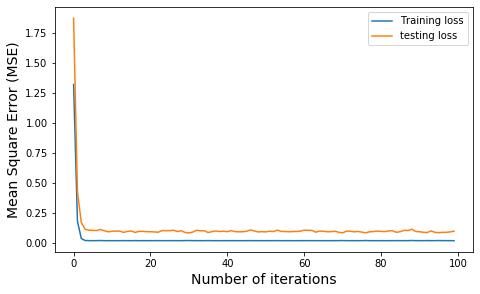

In [284]:
plt.figure(figsize=[5*1.5,3*1.5])
plt.plot(range(len(train_loss)),train_loss,label="Training loss")
plt.plot(range(len(test_loss)),test_loss,label="testing loss")
plt.legend(loc='best')
plt.ylabel('Mean Square Error (MSE)', fontsize="14")
plt.xlabel('Number of iterations',fontsize="14")
plt.show()